<a href="https://colab.research.google.com/github/anilbhatt1/EVA4P1_S15B_Depth_FG_Detection/blob/master/EVA4P1_S15_Comb_FG_Depth_Prediction_Alb_Transforms(no_norm).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! nvidia-smi

Sat May 30 11:33:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    19W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import warnings
warnings.filterwarnings('ignore')
import zipfile
from zipfile import ZipFile
from pathlib import Path
from time import time
from datetime import datetime 
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import pkgutil
import importlib
import os
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload
import seaborn as sns
import io
import skimage
from skimage.transform import resize
from itertools import groupby
from tqdm.auto import tqdm
import gc
sns.set()

#import albumentations
#print(albumentations.__version__) # check version

# This is to install and use albumentations latest package v0.4.5
#album_version_needed = "0.4.5"
#if albumentations.__version__ != album_version_needed:
#  !pip install albumentations==0.4.5   # 0.4.5 is the latest albumentation version
print('Pytorch version:', torch.__version__)

!pip install kornia
from kornia.losses import SSIM
from kornia.losses import DiceLoss

Pytorch version: 1.5.0+cu101


### Unzip FG_BG, Mask, Depth and corresponding BG images from gdrive

In [0]:
t1 = time()
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Mask_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Depth_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/BG_and_Its_Flip.zip"
t2 = time()
print(f'FG_BG, Mask & Depth Copy took {(t2-t1)/60:.5f} minutes')

FG_BG, Mask & Depth Copy took 5.75229 minutes


### Copying Log file that contains FG_BG file names, their path in gdrive & corresponding BG file name from which they were made 

In [0]:
if os.path.exists('/content/FG_BG_Filename_withflip_Logs.txt'):
    print('Log file exists')    
else:  
    !cp '/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Filename_withflip_Logs.txt' '/content/'
    print('Copied Log File')

Copied Log File


### Copying SRC libraries from Github to Colab.

In [0]:
# Copying the code from github to colab
os.chdir('/content/')
!git clone https://github.com/anilbhatt1/EVA4P1_S15B_Depth_FG_Detection

Cloning into 'EVA4P1_S15B_Depth_FG_Detection'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 368 (delta 32), reused 0 (delta 0), pack-reused 307
Receiving objects: 100% (368/368), 13.49 MiB | 5.60 MiB/s, done.
Resolving deltas: 100% (175/175), done.


In [0]:
%cd '/content/EVA4P1_S15B_Depth_FG_Detection/src/dataset'
! ls

/content/EVA4P1_S15B_Depth_FG_Detection/src/dataset
Alb_data_transforms.py	datatransforms.py  make1data.py  makedata.py


### Importing modules from Colab data folder to Colab session 

In [0]:
os.chdir('/content/EVA4P1_S15B_Depth_FG_Detection/')
import src
from src.dataset import datatransforms as dtf
from src.dataset import makedata as md
from src.dataset import make1data as md1
from src.dataset import Alb_data_transforms as Alb
from src.models  import S15_FGDepth_models as ntwk
from src.losses  import Train as Train
from src.losses  import Test  as Test
from src.utils   import Freeze_Layers as Freeze

### Creating a list - content_list for FG_BG log file. This content_list will be used to create dataloader to pick-up input images randomly for both training and testing

In [0]:
log_fg_bg = open('/content/FG_BG_Filename_withflip_Logs.txt',"r")
content_list = log_fg_bg.readlines()
print('No: of records in log_fg_bg:',len(content_list))
print(content_list[0])
log_fg_bg.close()

data_root = Path('/content')
f1, f2, f3, f4 = data_root/'FG_BG_400K', data_root/'BG_and_Its_Flip', data_root/'FG_BG_Mask_400K',  \
                 data_root/'FG_BG_Depth_0_400K'

No: of records in log_fg_bg: 400000
Img_fg_bg_1.jpg,Img21.jpg,Image41.png,(192, 192, 108, 156, 51, 3, 159, 3, 51, 159, 159, 159)



In [0]:
bs_small  = 96
bs_medium = 96
bs_large  = 16
bs_test   = 96
rows = 5
img_save, model_save = 1500, 500
t0k, t10k, t80k, t160k, t220k, t260k, t280k, t360k, t390k, t400k  = 0, 10000, 80000, 160000, 220000,\
                                                                             260000, 280000, 360000,\
                                                                                     390000, 400000

### Creating tranforms. For test data, GT mask & GT depth only 'To Tensor' & 'Resize' is used.

In [0]:
import albumentations as A
lst = [(64,64),(96,96),(192,192)]
fg_bg_mean, fg_bg_stdev                    = [0.56670278, 0.49779153, 0.43632878], [0.25049532, 0.2468085, 0.25520498]
mask_mean,  mask_stdev                     = [0.20249742], [0.20249742]
depth_mean, depth_stdev                    = [0.32939295], [0.24930712]
bg_mean, bg_stdev                          = [0.58245822, 0.51269352, 0.43691653], [0.24252189, 0.24318804, 0.25401604]
fg_bg_transforms, bg_transforms, mask_transforms, depth_transforms = {}, {}, {}, {}
test_fg_bg_transforms, test_bg_transforms                          = {}, {}
for i in range(len(lst)):
    ht, wd = lst[i]
    cut_out_size = int(ht/4)
    fg_bg_transforms["t_{0}".format(i)] = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                     A.IAAAdditiveGaussianNoise(),
                                                                     A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                                                     #A.Normalize(mean=fg_bg_mean, std=fg_bg_stdev),
                                                                     A.Cutout(num_holes=1,max_h_size=cut_out_size,max_w_size=cut_out_size),])
    bg_transforms["t_{0}".format(i)]    = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                     A.IAAAdditiveGaussianNoise(),
                                                                     A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),])
                                                                     #A.Normalize(mean=bg_mean, std=bg_stdev),])
    mask_transforms["t_{0}".format(i)]  = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),])
                                                                     #A.Normalize(mean=mask_mean, std=mask_stdev),])
    depth_transforms["t_{0}".format(i)] = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),])
                                                                     #A.Normalize(mean=depth_mean, std=depth_stdev),])
    test_fg_bg_transforms["t_{0}" .format(i)]  = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),])
                                                                              #A.Normalize(mean=fg_bg_mean, std=fg_bg_stdev),])
    test_bg_transforms["t_{0}" .format(i)]        = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),])
                                                                              #A.Normalize(mean=bg_mean, std=bg_stdev),])

In [0]:
print(fg_bg_transforms)
print(bg_transforms)
print(mask_transforms)
print(depth_transforms)
print(test_fg_bg_transforms)
print(test_bg_transforms)

{'t_0': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f98a1813208>, 't_1': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f98a18139b0>, 't_2': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f98a17a4198>}
{'t_0': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f98a1813390>, 't_1': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f98a1813b38>, 't_2': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f98a17a4320>}
{'t_0': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f98a18134a8>, 't_1': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f98a1813c50>, 't_2': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f98a17a4438>}
{'t_0': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f98a18135c0>, 't_1': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0

### Creating dataloader using content_list. Since total 280K images are present in training set, 5 cohorts are created to manage the training volume.
- 0 - 80k    -> size 64x64    
- 80k - 160k -> size 64x64    
- 160k -220k -> size 64x64    
- 220k -260k -> size 96x96    
- 260k -280k -> size 192x192  
- 280k -400k -> size 64x64 -> Test dataset

In [0]:
train_ds_mini_1    = md1.Make1data(f1, content_list, t0k, t80k,  
                             fg_bg_transforms['t_0'],bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
train_ds_mini_2    = md1.Make1data(f1, content_list, t80k, t160k,  
                             fg_bg_transforms['t_0'],bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
train_ds_mini_3    = md1.Make1data(f1, content_list, t160k, t220k,  
                             fg_bg_transforms['t_0'],bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
train_ds_medium    = md1.Make1data(f1, content_list, t220k, t260k,  
                             fg_bg_transforms['t_1'],bg_transforms['t_1'],mask_transforms['t_1'],depth_transforms['t_1'])
train_ds_large   = md1.Make1data(f1, content_list, t260k, t280k,  
                             fg_bg_transforms['t_2'],bg_transforms['t_2'],mask_transforms['t_2'],depth_transforms['t_2'])
test_ds          = md1.Make1data(f1, content_list, t280k, t400k,  
                             test_fg_bg_transforms['t_0'],test_bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])

In [0]:
train_dl_mini_1  = DataLoader(train_ds_mini_1, batch_size = bs_small,shuffle = True, pin_memory = True)
train_dl_mini_2  = DataLoader(train_ds_mini_2, batch_size = bs_small,shuffle = True, pin_memory = True)
train_dl_mini_3  = DataLoader(train_ds_mini_3, batch_size = bs_small,  shuffle = True, pin_memory = True)
train_dl_medium  = DataLoader(train_ds_medium, batch_size = bs_medium, shuffle = True, pin_memory = True)
train_dl_large   = DataLoader(train_ds_large,  batch_size = bs_large, shuffle = True, pin_memory = True)
test_dl          = DataLoader(test_ds,         batch_size = bs_test,  shuffle = True, pin_memory = True)

### To check if batch & sizes are coming correctly & whether dataloader and transforms are working as expected

In [0]:
images_mini_1 = next(iter(train_dl_mini_1))
images_mini_2 = next(iter(train_dl_mini_2))
images_mini_3 = next(iter(train_dl_mini_3))
images_medium = next(iter(train_dl_medium))
images_large  = next(iter(train_dl_large))
images_test   = next(iter(test_dl))

In [0]:
print('B1:',[(k, v.shape) for k, v in images_mini_1.items()])
print('B2:',[(k, v.shape) for k, v in images_mini_2.items()])
print('B3:',[(k, v.shape) for k, v in images_mini_3.items()])
print('B4:',[(k, v.shape) for k, v in images_medium.items()])
print('B5:',[(k, v.shape) for k, v in images_large.items()])
print('B6:',[(k, v.shape) for k, v in images_test.items()])

B1: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]
B2: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]
B3: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]
B4: [('f1', torch.Size([96, 3, 96, 96])), ('f2', torch.Size([96, 3, 96, 96])), ('f3', torch.Size([96, 1, 96, 96])), ('f4', torch.Size([96, 1, 96, 96]))]
B5: [('f1', torch.Size([16, 3, 192, 192])), ('f2', torch.Size([16, 3, 192, 192])), ('f3', torch.Size([16, 1, 192, 192])), ('f4', torch.Size([16, 1, 192, 192]))]
B6: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]


### To display images created out of dataloader & transform to ensure images are coming out for display correctly

In [0]:
imgs = images_large['f1']

In [0]:
def show(tensors, figsize= (10,10), *args, **kwargs):
  grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)  
  grid_image  = grid_tensor.permute(1, 2, 0)
  plt.figure(figsize = figsize)
  plt.imshow(grid_image)
  plt.xticks([])  
  plt.yticks([])
  plt.show()

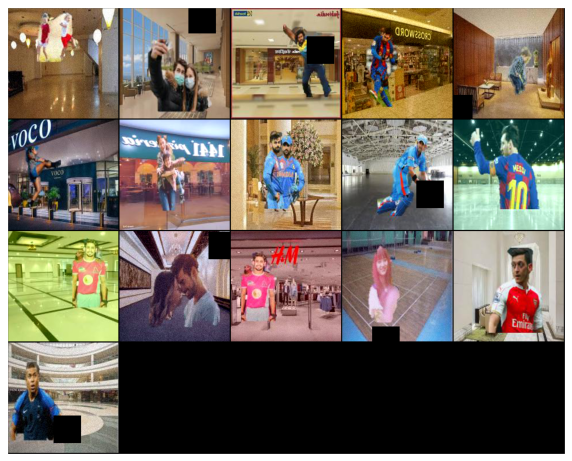

In [0]:
show(imgs, nrow=rows)

### Initializing the model and assigning it to Cuda

In [0]:
model = ntwk.FGDepth()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)

FGDepth(
  (convA): Sequential(
    (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convB): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (convC): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convD): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (convE): Sequential(
    (0): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (blck1): DownSize(
  

### Defining Freeze class. We are using transfer learning & hence this class will be used to freeze the layers as required.

In [0]:
freezer = Freeze.Freezer()

### Defining Loss Criterion & creating scheduler

In [0]:
#criterion  = nn.BCEWithLogitsLoss()
criterion1  = DiceLoss()
kernel_size = 3
criterion2  = SSIM(kernel_size, reduction = 'mean')

optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9, weight_decay = 1e-5)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optim, step_size=2, gamma=0.1)

### Defining train & test loss classes

In [0]:
train_loss_fn = Train.Training_loss()
test_loss_fn  = Test.Testing_loss()

### Reloading model from last saved weights that are present in gdrive

In [0]:
path = f'/content/gdrive/My Drive/FG_Depth_Prediction_0530V17A.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [0]:
path_name       = '/content/gdrive/My Drive/plots_0530_V17A/'

In [0]:
path_name       = '/content/gdrive/My Drive/plots_0530_V17A/'
path_model_save = f'/content/gdrive/My Drive/FG_Depth_Prediction_0530V17A.pt'

file_name  = 'train_log.txt'
log_file    = open(f'{path_name}{file_name}','w')
log_file.close()
file_name  = 'test_log.txt'
log_file   = open(f'{path_name}{file_name}','w') 
log_file.close()    

### Train & Test the model

In [0]:
train_loss_all, train_mask_loss_all, train_depth_loss_all, train_mask_iou_all, train_depth_iou_all = [], [], [], [], []
test_loss_all,  test_mask_loss_all,  test_depth_loss_all,  test_mask_iou_all,  test_depth_iou_all  = [], [], [], [], []

for epoch in range(1,11):
  train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = 0, 0, 0, 0, 0
  test_loss,  test_mask_loss,  test_depth_loss,  test_mask_iou,  test_depth_iou  = 0, 0, 0, 0, 0
  if epoch < 2:
     batch_size, loader = bs_small, train_dl_mini_1
     freezer.freeze_mask_layers(model)
  elif epoch < 3:
     batch_size, loader  = bs_small, train_dl_mini_2
     freezer.freeze_mask_layers(model)    
  elif epoch < 4:
     batch_size, loader = bs_small, train_dl_mini_3
     freezer.freeze_mask_layers(model)  
  elif epoch < 5:
     batch_size, loader  = bs_medium, train_dl_medium
     freezer.freeze_mask_layers(model)  
  elif epoch < 6:
     batch_size, loader  = bs_large, train_dl_large
     freezer.freeze_mask_layers(model)
  elif epoch < 7:
     batch_size, loader = bs_small,  train_dl_mini_1
     freezer.freeze_depth_layers(model)
  elif epoch < 8:
     batch_size, loader  = bs_small, train_dl_mini_2
     freezer.freeze_depth_layers(model) 
  elif epoch < 9:
     batch_size, loader  = bs_small, train_dl_mini_3
     freezer.freeze_depth_layers(model)  
  elif epoch < 10:
     batch_size, loader = bs_medium, train_dl_medium
     freezer.freeze_depth_layers(model)  
  elif epoch < 11:
     batch_size, loader = bs_large, train_dl_large
     freezer.freeze_depth_layers(model)      

  train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc( \
                                                           model, model.device, loader,\
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  batch_size, loader = bs_test, test_dl
  test_loss, test_mask_loss, test_depth_loss, test_mask_iou, test_depth_iou = test_loss_fn.test_loss_calc(             \
                                                         model, model.device, loader, optim,                           \
                                                         epoch, criterion1, criterion2, batch_size, path_name,         \
                                                         scheduler, img_save)
  scheduler.step()

  train_loss_all.append(train_loss.item()), train_mask_loss_all.append(train_mask_loss.item()), train_depth_loss_all.append(train_depth_loss.item())
  test_loss_all.append(test_loss.item()),   test_mask_loss_all.append(test_mask_loss.item()),   test_depth_loss_all.append(test_depth_loss.item())
  train_mask_iou_all.append(train_mask_iou), train_depth_iou_all.append(train_depth_iou)
  test_mask_iou_all.append(test_mask_iou),   test_depth_iou_all.append(test_depth_iou)

  gc.collect()

  0%|          | 0/834 [00:00<?, ?it/s]

Freezing Mask Layers


TR1|0|0.072|0.156|0.409|0.317:   0%|          | 0/834 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:1 Batch_ID: 0 [0/80000 (0%)]	Loss:0.29917 Mask_Loss:0.07181 Dpth_Loss:0.15555 Mask_IOU:0.40892 Dpth_IOU: 0.31711


TR1|0|0.072|0.156|0.409|0.317:   0%|          | 1/834 [00:02<34:37,  2.49s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0530V17A.pt Epoch & Batch-ID: 1 0


TR1|500|0.069|0.116|0.368|0.601:  60%|██████    | 501/834 [07:35<05:33,  1.00s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0530V17A.pt Epoch & Batch-ID: 1 500


TR1|832|0.068|0.113|0.387|0.594: 100%|█████████▉| 832/834 [12:33<00:01,  1.12it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:1 Batch_ID: 832 [79872/80000 (100%)]	Loss:0.24754 Mask_Loss:0.06750 Dpth_Loss:0.11253 Mask_IOU:0.38698 Dpth_IOU: 0.59440


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR1|833|0.073|0.122|0.388|0.567: 100%|██████████| 834/834 [12:34<00:00,  1.10it/s]
TS1|0|0.072|0.112|0.491|0.571:   0%|          | 0/1250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 1 [0/120000 (0%)]	Test_Loss: 0.255452 Mask_Loss: 0.07179 Dpth_Loss: 0.11187 Mask_IOU: 0.49126 Dpth_IOU: 0.57107


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS1|1249|0.073|0.104|0.491|0.626: 100%|█████████▉| 1249/1250 [14:35<00:00,  1.46it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 1 [6245/120000 (100%)]	Test_Loss: 0.249348 Mask_Loss: 0.07252 Dpth_Loss: 0.10431 Mask_IOU: 0.49059 Dpth_IOU: 0.62559


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS1|1249|0.073|0.104|0.491|0.626: 100%|██████████| 1250/1250 [14:36<00:00,  1.43it/s]
  0%|          | 0/834 [00:00<?, ?it/s]

Freezing Mask Layers


TR2|0|0.075|0.112|0.373|0.577:   0%|          | 0/834 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:2 Batch_ID: 0 [0/80000 (0%)]	Loss:0.26166 Mask_Loss:0.07504 Dpth_Loss:0.11159 Mask_IOU:0.37289 Dpth_IOU: 0.57683


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR2|0|0.075|0.112|0.373|0.577:   0%|          | 1/834 [00:02<38:24,  2.77s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0530V17A.pt Epoch & Batch-ID: 2 0


TR2|500|0.075|0.116|0.373|0.601:  60%|██████    | 501/834 [07:26<05:25,  1.02it/s]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0530V17A.pt Epoch & Batch-ID: 2 500


TR2|832|0.072|0.111|0.394|0.615: 100%|█████████▉| 832/834 [12:18<00:01,  1.16it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:2 Batch_ID: 832 [79872/80000 (100%)]	Loss:0.25487 Mask_Loss:0.07217 Dpth_Loss:0.11054 Mask_IOU:0.39385 Dpth_IOU: 0.61457


TR2|833|0.078|0.116|0.407|0.595: 100%|██████████| 834/834 [12:20<00:00,  1.13it/s]
TS2|0|0.069|0.103|0.470|0.719:   0%|          | 0/1250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 2 [0/120000 (0%)]	Test_Loss: 0.240885 Mask_Loss: 0.06885 Dpth_Loss: 0.10318 Mask_IOU: 0.47036 Dpth_IOU: 0.71866


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS2|1249|0.071|0.107|0.481|0.688: 100%|█████████▉| 1249/1250 [13:53<00:00,  1.53it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 2 [6245/120000 (100%)]	Test_Loss: 0.247981 Mask_Loss: 0.07070 Dpth_Loss: 0.10658 Mask_IOU: 0.48120 Dpth_IOU: 0.68753


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS2|1249|0.071|0.107|0.481|0.688: 100%|██████████| 1250/1250 [13:54<00:00,  1.50it/s]
  0%|          | 0/625 [00:00<?, ?it/s]

Freezing Mask Layers


TR3|0|0.077|0.113|0.384|0.591:   0%|          | 0/625 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:3 Batch_ID: 0 [0/60000 (0%)]	Loss:0.26573 Mask_Loss:0.07660 Dpth_Loss:0.11253 Mask_IOU:0.38436 Dpth_IOU: 0.59064


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR3|0|0.077|0.113|0.384|0.591:   0%|          | 1/625 [00:02<26:01,  2.50s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0530V17A.pt Epoch & Batch-ID: 3 0


TR3|500|0.070|0.106|0.405|0.616:  80%|████████  | 501/625 [07:21<02:05,  1.01s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0530V17A.pt Epoch & Batch-ID: 3 500


TR3|624|0.077|0.106|0.377|0.600: 100%|█████████▉| 624/625 [09:11<00:00,  1.13it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:3 Batch_ID: 624 [59904/60000 (100%)]	Loss:0.25998 Mask_Loss:0.07724 Dpth_Loss:0.10551 Mask_IOU:0.37694 Dpth_IOU: 0.60003


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR3|624|0.077|0.106|0.377|0.600: 100%|██████████| 625/625 [09:12<00:00,  1.13it/s]
TS3|0|0.066|0.091|0.474|0.678:   0%|          | 0/1250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 3 [0/120000 (0%)]	Test_Loss: 0.223152 Mask_Loss: 0.06585 Dpth_Loss: 0.09144 Mask_IOU: 0.47387 Dpth_IOU: 0.67815


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS3|1249|0.073|0.097|0.490|0.684: 100%|█████████▉| 1249/1250 [13:36<00:00,  1.52it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 3 [6245/120000 (100%)]	Test_Loss: 0.242355 Mask_Loss: 0.07283 Dpth_Loss: 0.09669 Mask_IOU: 0.49029 Dpth_IOU: 0.68374


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS3|1249|0.073|0.097|0.490|0.684: 100%|██████████| 1250/1250 [13:37<00:00,  1.53it/s]
  0%|          | 0/417 [00:00<?, ?it/s]

Freezing Mask Layers


TR4|0|0.063|0.147|0.392|0.414:   0%|          | 0/417 [00:01<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:4 Batch_ID: 0 [0/40000 (0%)]	Loss:0.27264 Mask_Loss:0.06306 Dpth_Loss:0.14651 Mask_IOU:0.39189 Dpth_IOU: 0.41384


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR4|0|0.063|0.147|0.392|0.414:   0%|          | 1/417 [00:03<25:24,  3.67s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0530V17A.pt Epoch & Batch-ID: 4 0


TR4|415|0.065|0.114|0.394|0.456: 100%|█████████▉| 415/417 [07:46<00:02,  1.13s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:4 Batch_ID: 415 [39840/40000 (100%)]	Loss:0.24399 Mask_Loss:0.06490 Dpth_Loss:0.11418 Mask_IOU:0.39373 Dpth_IOU: 0.45559


TR4|416|0.069|0.121|0.420|0.414: 100%|██████████| 417/417 [07:50<00:00,  1.13s/it]
TS4|0|0.069|0.119|0.455|0.476:   0%|          | 0/1250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 4 [0/120000 (0%)]	Test_Loss: 0.257991 Mask_Loss: 0.06935 Dpth_Loss: 0.11930 Mask_IOU: 0.45522 Dpth_IOU: 0.47592


TS4|1249|0.075|0.125|0.463|0.482: 100%|█████████▉| 1249/1250 [12:56<00:00,  1.49it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 4 [6245/120000 (100%)]	Test_Loss: 0.273797 Mask_Loss: 0.07453 Dpth_Loss: 0.12474 Mask_IOU: 0.46334 Dpth_IOU: 0.48197


TS4|1249|0.075|0.125|0.463|0.482: 100%|██████████| 1250/1250 [12:58<00:00,  1.61it/s]
  0%|          | 0/1250 [00:00<?, ?it/s]

Freezing Mask Layers


TR5|0|0.083|0.135|0.377|0.288:   0%|          | 0/1250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:5 Batch_ID: 0 [0/20000 (0%)]	Loss:0.30141 Mask_Loss:0.08325 Dpth_Loss:0.13492 Mask_IOU:0.37665 Dpth_IOU: 0.28786


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR5|0|0.083|0.135|0.377|0.288:   0%|          | 1/1250 [00:02<42:07,  2.02s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0530V17A.pt Epoch & Batch-ID: 5 0


TR5|500|0.078|0.103|0.400|0.178:  40%|████      | 501/1250 [04:45<08:42,  1.43it/s]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0530V17A.pt Epoch & Batch-ID: 5 500


TR5|1000|0.081|0.116|0.356|0.154:  80%|████████  | 1001/1250 [09:27<02:53,  1.44it/s]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0530V17A.pt Epoch & Batch-ID: 5 1000


TR5|1249|0.078|0.115|0.368|0.273: 100%|█████████▉| 1249/1250 [11:48<00:00,  1.76it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:5 Batch_ID: 1249 [19984/20000 (100%)]	Loss:0.27168 Mask_Loss:0.07829 Dpth_Loss:0.11510 Mask_IOU:0.36837 Dpth_IOU: 0.27304


TR5|1249|0.078|0.115|0.368|0.273: 100%|██████████| 1250/1250 [11:50<00:00,  1.76it/s]
TS5|0|0.082|0.175|0.455|0.038:   0%|          | 0/1250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 5 [0/120000 (0%)]	Test_Loss: 0.338392 Mask_Loss: 0.08170 Dpth_Loss: 0.17499 Mask_IOU: 0.45516 Dpth_IOU: 0.03830


TS5|1249|0.077|0.183|0.433|0.030: 100%|█████████▉| 1249/1250 [11:04<00:00,  1.63it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 5 [6245/120000 (100%)]	Test_Loss: 0.337925 Mask_Loss: 0.07740 Dpth_Loss: 0.18313 Mask_IOU: 0.43262 Dpth_IOU: 0.02952


TS5|1249|0.077|0.183|0.433|0.030: 100%|██████████| 1250/1250 [11:05<00:00,  1.88it/s]
  0%|          | 0/834 [00:00<?, ?it/s]

Freezing Depth Layers


TR6|0|0.070|0.156|0.400|0.275:   0%|          | 0/834 [00:01<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:6 Batch_ID: 0 [0/80000 (0%)]	Loss:0.29553 Mask_Loss:0.06968 Dpth_Loss:0.15618 Mask_IOU:0.39962 Dpth_IOU: 0.27501


TR6|0|0.070|0.156|0.400|0.275:   0%|          | 1/834 [00:02<37:15,  2.68s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0530V17A.pt Epoch & Batch-ID: 6 0


TR6|500|0.074|0.146|0.444|0.282:  60%|██████    | 501/834 [07:27<05:22,  1.03it/s]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0530V17A.pt Epoch & Batch-ID: 6 500


TR6|832|0.072|0.150|0.387|0.308: 100%|█████████▉| 832/834 [12:19<00:01,  1.15it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:6 Batch_ID: 832 [79872/80000 (100%)]	Loss:0.29408 Mask_Loss:0.07191 Dpth_Loss:0.15027 Mask_IOU:0.38730 Dpth_IOU: 0.30781


TR6|833|0.073|0.144|0.466|0.303: 100%|██████████| 834/834 [12:21<00:00,  1.13it/s]
TS6|0|0.075|0.140|0.515|0.333:   0%|          | 0/1250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 6 [0/120000 (0%)]	Test_Loss: 0.290510 Mask_Loss: 0.07531 Dpth_Loss: 0.13990 Mask_IOU: 0.51522 Dpth_IOU: 0.33294


TS6|1249|0.075|0.136|0.520|0.321: 100%|█████████▉| 1249/1250 [12:50<00:00,  1.54it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 6 [6245/120000 (100%)]	Test_Loss: 0.285486 Mask_Loss: 0.07467 Dpth_Loss: 0.13615 Mask_IOU: 0.51983 Dpth_IOU: 0.32077


TS6|1249|0.075|0.136|0.520|0.321: 100%|██████████| 1250/1250 [12:51<00:00,  1.62it/s]
  0%|          | 0/834 [00:00<?, ?it/s]

Freezing Depth Layers


TR7|0|0.070|0.145|0.418|0.246:   0%|          | 0/834 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:7 Batch_ID: 0 [0/80000 (0%)]	Loss:0.28456 Mask_Loss:0.06964 Dpth_Loss:0.14527 Mask_IOU:0.41798 Dpth_IOU: 0.24584


TR7|0|0.070|0.145|0.418|0.246:   0%|          | 1/834 [00:02<35:21,  2.55s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0530V17A.pt Epoch & Batch-ID: 7 0


TR7|500|0.079|0.151|0.395|0.295:  60%|██████    | 501/834 [07:17<05:15,  1.05it/s]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0530V17A.pt Epoch & Batch-ID: 7 500


TR7|832|0.076|0.151|0.406|0.266: 100%|█████████▉| 832/834 [12:04<00:01,  1.16it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:7 Batch_ID: 832 [79872/80000 (100%)]	Loss:0.30246 Mask_Loss:0.07579 Dpth_Loss:0.15088 Mask_IOU:0.40582 Dpth_IOU: 0.26612


TR7|833|0.083|0.153|0.399|0.258: 100%|██████████| 834/834 [12:06<00:00,  1.15it/s]
TS7|0|0.073|0.142|0.501|0.383:   0%|          | 0/1250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 7 [0/120000 (0%)]	Test_Loss: 0.287192 Mask_Loss: 0.07264 Dpth_Loss: 0.14192 Mask_IOU: 0.50101 Dpth_IOU: 0.38299


TS7|1249|0.079|0.140|0.513|0.321: 100%|█████████▉| 1249/1250 [13:41<00:00,  1.47it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 7 [6245/120000 (100%)]	Test_Loss: 0.298133 Mask_Loss: 0.07910 Dpth_Loss: 0.13994 Mask_IOU: 0.51316 Dpth_IOU: 0.32107


TS7|1249|0.079|0.140|0.513|0.321: 100%|██████████| 1250/1250 [13:42<00:00,  1.52it/s]
  0%|          | 0/625 [00:00<?, ?it/s]

Freezing Depth Layers


TR8|0|0.073|0.148|0.387|0.260:   0%|          | 0/625 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:8 Batch_ID: 0 [0/60000 (0%)]	Loss:0.29489 Mask_Loss:0.07325 Dpth_Loss:0.14839 Mask_IOU:0.38689 Dpth_IOU: 0.25985


TR8|0|0.073|0.148|0.387|0.260:   0%|          | 1/625 [00:02<26:29,  2.55s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0530V17A.pt Epoch & Batch-ID: 8 0


TR8|500|0.077|0.146|0.422|0.253:  80%|████████  | 501/625 [07:21<02:02,  1.02it/s]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0530V17A.pt Epoch & Batch-ID: 8 500


TR8|624|0.075|0.146|0.418|0.277: 100%|█████████▉| 624/625 [09:10<00:00,  1.14it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:8 Batch_ID: 624 [59904/60000 (100%)]	Loss:0.29504 Mask_Loss:0.07472 Dpth_Loss:0.14561 Mask_IOU:0.41814 Dpth_IOU: 0.27719


TR8|624|0.075|0.146|0.418|0.277: 100%|██████████| 625/625 [09:11<00:00,  1.13it/s]
TS8|0|0.074|0.137|0.501|0.312:   0%|          | 0/1250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 8 [0/120000 (0%)]	Test_Loss: 0.285054 Mask_Loss: 0.07408 Dpth_Loss: 0.13689 Mask_IOU: 0.50113 Dpth_IOU: 0.31226


TS8|1249|0.070|0.138|0.516|0.393: 100%|█████████▉| 1249/1250 [13:47<00:00,  1.47it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 8 [6245/120000 (100%)]	Test_Loss: 0.278585 Mask_Loss: 0.07035 Dpth_Loss: 0.13788 Mask_IOU: 0.51625 Dpth_IOU: 0.39339


TS8|1249|0.070|0.138|0.516|0.393: 100%|██████████| 1250/1250 [13:48<00:00,  1.51it/s]
  0%|          | 0/417 [00:00<?, ?it/s]

Freezing Depth Layers


TR9|0|0.071|0.133|0.412|0.216:   0%|          | 0/417 [00:01<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:9 Batch_ID: 0 [0/40000 (0%)]	Loss:0.27432 Mask_Loss:0.07085 Dpth_Loss:0.13262 Mask_IOU:0.41201 Dpth_IOU: 0.21571


TR9|0|0.071|0.133|0.412|0.216:   0%|          | 1/417 [00:03<25:33,  3.69s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0530V17A.pt Epoch & Batch-ID: 9 0


TR9|415|0.071|0.128|0.437|0.221: 100%|█████████▉| 415/417 [07:44<00:02,  1.10s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:9 Batch_ID: 415 [39840/40000 (100%)]	Loss:0.27070 Mask_Loss:0.07140 Dpth_Loss:0.12791 Mask_IOU:0.43671 Dpth_IOU: 0.22111


TR9|416|0.066|0.131|0.397|0.224: 100%|██████████| 417/417 [07:47<00:00,  1.12s/it]
TS9|0|0.074|0.151|0.540|0.093:   0%|          | 0/1250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 9 [0/120000 (0%)]	Test_Loss: 0.299123 Mask_Loss: 0.07410 Dpth_Loss: 0.15092 Mask_IOU: 0.54002 Dpth_IOU: 0.09280


TS9|1249|0.079|0.152|0.550|0.083: 100%|█████████▉| 1249/1250 [13:41<00:00,  1.47it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 9 [6245/120000 (100%)]	Test_Loss: 0.309782 Mask_Loss: 0.07873 Dpth_Loss: 0.15232 Mask_IOU: 0.55018 Dpth_IOU: 0.08301


TS9|1249|0.079|0.152|0.550|0.083: 100%|██████████| 1250/1250 [13:42<00:00,  1.52it/s]
  0%|          | 0/1250 [00:00<?, ?it/s]

Freezing Depth Layers


TR10|0|0.086|0.114|0.351|0.220:   0%|          | 0/1250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:10 Batch_ID: 0 [0/20000 (0%)]	Loss:0.28480 Mask_Loss:0.08558 Dpth_Loss:0.11365 Mask_IOU:0.35093 Dpth_IOU: 0.22015


TR10|0|0.086|0.114|0.351|0.220:   0%|          | 1/1250 [00:02<42:11,  2.03s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0530V17A.pt Epoch & Batch-ID: 10 0


TR10|500|0.081|0.115|0.362|0.237:  40%|████      | 501/1250 [04:29<08:11,  1.52it/s]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0530V17A.pt Epoch & Batch-ID: 10 500


TR10|1000|0.080|0.113|0.401|0.240:  80%|████████  | 1001/1250 [08:56<02:43,  1.52it/s]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0530V17A.pt Epoch & Batch-ID: 10 1000


TR10|1249|0.088|0.129|0.349|0.167: 100%|█████████▉| 1249/1250 [11:08<00:00,  1.88it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:10 Batch_ID: 1249 [19984/20000 (100%)]	Loss:0.30470 Mask_Loss:0.08788 Dpth_Loss:0.12894 Mask_IOU:0.34942 Dpth_IOU: 0.16744


TR10|1249|0.088|0.129|0.349|0.167: 100%|██████████| 1250/1250 [11:10<00:00,  1.87it/s]
TS10|0|0.073|0.174|0.519|0.014:   0%|          | 0/1250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 10 [0/120000 (0%)]	Test_Loss: 0.319550 Mask_Loss: 0.07264 Dpth_Loss: 0.17428 Mask_IOU: 0.51940 Dpth_IOU: 0.01359


TS10|1249|0.077|0.172|0.495|0.020: 100%|█████████▉| 1249/1250 [13:15<00:00,  1.39it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 10 [6245/120000 (100%)]	Test_Loss: 0.326163 Mask_Loss: 0.07719 Dpth_Loss: 0.17178 Mask_IOU: 0.49460 Dpth_IOU: 0.02013


TS10|1249|0.077|0.172|0.495|0.020: 100%|██████████| 1250/1250 [13:16<00:00,  1.57it/s]


In [0]:
print('train_loss_all:',train_loss_all)
print('train_mask_loss_all:',train_mask_loss_all)
print('train_depth_loss_all:',train_depth_loss_all)
print('train_mask_iou_all:',train_mask_iou_all)
print('train_depth_iou_all:',train_depth_iou_all)
print('test_loss_all:',test_loss_all)
print('test_mask_loss_all:',test_mask_loss_all)
print('test_depth_loss_all:',test_depth_loss_all)
print('test_mask_iou_all:',test_mask_iou_all)
print('test_depth_iou_all:',test_depth_iou_all)

train_loss_all: [0.2656266391277313, 0.26607492566108704, 0.2587227523326874, 0.26009586453437805, 0.27144595980644226, 0.3005323112010956, 0.29820379614830017, 0.29762008786201477, 0.2680186629295349, 0.27076998353004456]
train_mask_loss_all: [0.07477426528930664, 0.0747901126742363, 0.0746774896979332, 0.06868378818035126, 0.07696688920259476, 0.07495339214801788, 0.0748143196105957, 0.07463087886571884, 0.06883816421031952, 0.07662796229124069]
train_depth_loss_all: [0.11607804149389267, 0.11649469286203384, 0.10936800390481949, 0.12272842973470688, 0.11751221865415573, 0.15062560141086578, 0.14857526123523712, 0.14835815131664276, 0.1303422749042511, 0.11751445382833481]
train_mask_iou_all: [0.3875719766311299, 0.38808167382316117, 0.38799178060458, 0.4011079782008151, 0.36395886102828706, 0.4133161513010454, 0.4239468674315337, 0.42335049041771217, 0.41551410659242155, 0.36602836048723786]
train_depth_iou_all: [0.5819158933083068, 0.5802055493291048, 0.6132352172567224, 0.39973008

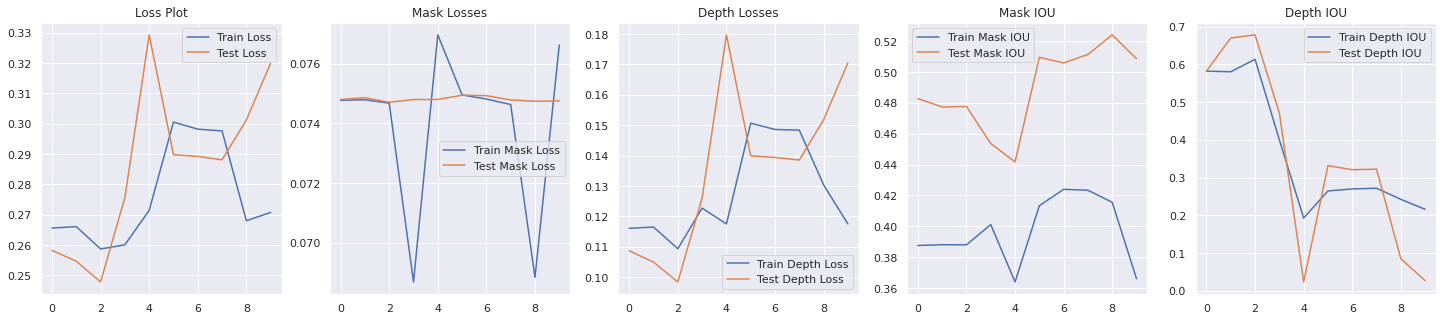

In [0]:
 
figure = plt.figure(figsize=(25,5))

plt.subplot(1,5,1)
plt.title("Loss Plot")
plt.plot(train_loss_all,label='Train Loss')
plt.plot(test_loss_all, label='Test Loss')
plt.legend(loc="best")

plt.subplot(1,5,2)
plt.title("Mask Losses")
plt.plot(train_mask_loss_all,label='Train Mask Loss')
plt.plot(test_mask_loss_all, label='Test Mask Loss')
plt.legend(loc="best")

plt.subplot(1,5,3)
plt.title("Depth Losses")
plt.plot(train_depth_loss_all,label='Train Depth Loss')
plt.plot(test_depth_loss_all, label='Test Depth Loss')
plt.legend(loc="best")

plt.subplot(1,5,4)
plt.title("Mask IOU")
plt.plot(train_mask_iou_all,label='Train Mask IOU')
plt.plot(test_mask_iou_all, label='Test Mask IOU')
plt.legend(loc="best")

plt.subplot(1,5,5)
plt.title("Depth IOU")
plt.plot(train_depth_iou_all,label='Train Depth IOU')
plt.plot(test_depth_iou_all, label='Test Depth IOU')
plt.legend(loc="best")

In [0]:
test_ds_display = md1.Make1data(f1, content_list, 390000, t400k,  
                  test_fg_bg_transforms['t_0'],test_bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
test_dl_display = DataLoader(test_ds_display, batch_size = 8,  shuffle = True, pin_memory = True)
batch_size, loader = 8, test_dl_display
epoch = 11
test_loss, test_mask_loss, test_depth_loss, test_mask_iou, test_depth_iou = test_loss_fn.test_loss_calc(             \
                                                         model, model.device, loader, optim,                           \
                                                         epoch, criterion1, criterion2, batch_size, path_name,         \
                                                         scheduler, img_save)

TS11|0|0.103|0.178|0.516|0.081:   0%|          | 0/1250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 11 [0/10000 (0%)]	Test_Loss: 0.384727 Mask_Loss: 0.10322 Dpth_Loss: 0.17828 Mask_IOU: 0.51633 Dpth_IOU: 0.08073


TS11|1249|0.067|0.183|0.538|0.000: 100%|█████████▉| 1249/1250 [00:56<00:00, 22.04it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 11 [6245/10000 (100%)]	Test_Loss: 0.316712 Mask_Loss: 0.06680 Dpth_Loss: 0.18311 Mask_IOU: 0.53792 Dpth_IOU: 0.00000


TS11|1249|0.067|0.183|0.538|0.000: 100%|██████████| 1250/1250 [00:56<00:00, 22.15it/s]
